In [ ]:
!wget https://github.com/dmylzenova/speech_processing/raw/autumn_23/week05/mystery_records.pickle
!wget https://github.com/dmylzenova/speech_processing/raw/autumn_23/week05/lj_batch.pickle

--2023-10-25 11:46:00--  https://github.com/dmylzenova/speech_processing/raw/autumn_23/week05/mystery_records.pickle
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmylzenova/speech_processing/autumn_23/week05/mystery_records.pickle [following]
--2023-10-25 11:46:00--  https://raw.githubusercontent.com/dmylzenova/speech_processing/autumn_23/week05/mystery_records.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147439 (144K) [application/octet-stream]
Saving to: ‘mystery_records.pickle’

mystery_records.pic 100%[===================>] 143.98K  --.-KB/s    in 0.02s   

2023-10-25 11:46:01 (

## Computing WER and CER

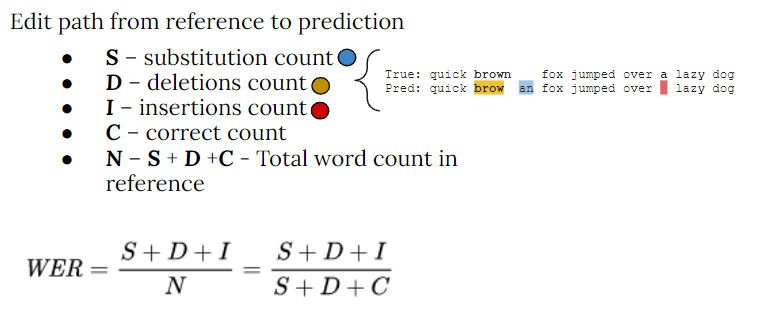

**Задание**: Напишите код для подсчета метрик CER & WER

In [ ]:
# library for fast quick calculation of edit distance
import editdistance

def calc_wer(target_text: str, pred_text: str):
    return editdistance.distance(target_text.split(), pred_text.split()) / len(target_text.split())


def calc_cer(target_text: str, pred_text: str):
    return editdistance.distance(target_text, pred_text) / len(target_text)

In [ ]:
import numpy as np

for target, pred, expected_wer, expected_cer in [
    ("if you can not measure it you can not improve it",
     "if you can nt measure t yo can not i",
     0.454, 0.25),
    ("if you cant describe what you are doing as a process you dont know what youre doing",
     "if you cant describe what you are doing as a process you dont know what youre doing",
     0.0, 0.0),
    ("one measurement is worth a thousand expert opinions",
     "one  is worth thousand opinions",
     0.375, 0.392)
]:
    wer = calc_wer(target, pred)
    cer = calc_cer(target, pred)
    assert np.isclose(wer, expected_wer, atol=1e-3), f"true: {target}, pred: {pred}, expected wer {expected_wer} != your wer {wer}"
    assert np.isclose(cer, expected_cer, atol=1e-3), f"true: {target}, pred: {pred}, expected cer {expected_cer} != your cer {cer}"

## Decoding CTC output

Один из простейших способов декодирования предсказаний для модели, обученной с `CTC` лоссом это склеить повторяющиеся символы и удалить пустые:

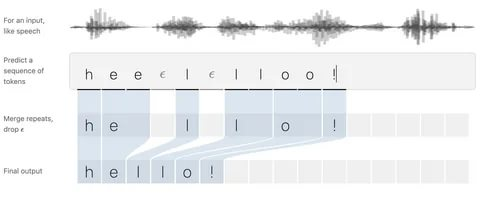

In [ ]:
import pickle
import torch


# Load precomputed CTC output
with open('mystery_records.pickle', 'rb') as f:
    batch = pickle.load(f)

# log probabilities of softmax layers [batch_size, T, vocab_size]
log_probs = batch["log_probs"]

# Dictionary with index to character mapping
ind2char = batch["ind2char"]

# Index of special EMPTY token
EMPTY_TOK = '^'
EMPTY_IND = 0

**Задание**: Напишите код для декодирования CTC

In [ ]:
def ctc_decode(inds, ind2char):
    last = ind2char[0]
    seq = []
    for i in inds:
        ch = ind2char[i]
        if ch != last and i != 0:
            seq.append(ch)
            last = ch
    return "".join(seq)

for i, rec in enumerate(log_probs):
    text = ctc_decode(rec.argmax(-1).numpy(), ind2char)
    print(f"{i}) {text}")

0) we nostrngesto love you know therols and so do i a fol comitment what i thinking of you wolden get this from any ather guy
1)  never gona give you up never donelet you down never go arun around and deset you never gon a make you cri never gona say god by


## Beam search

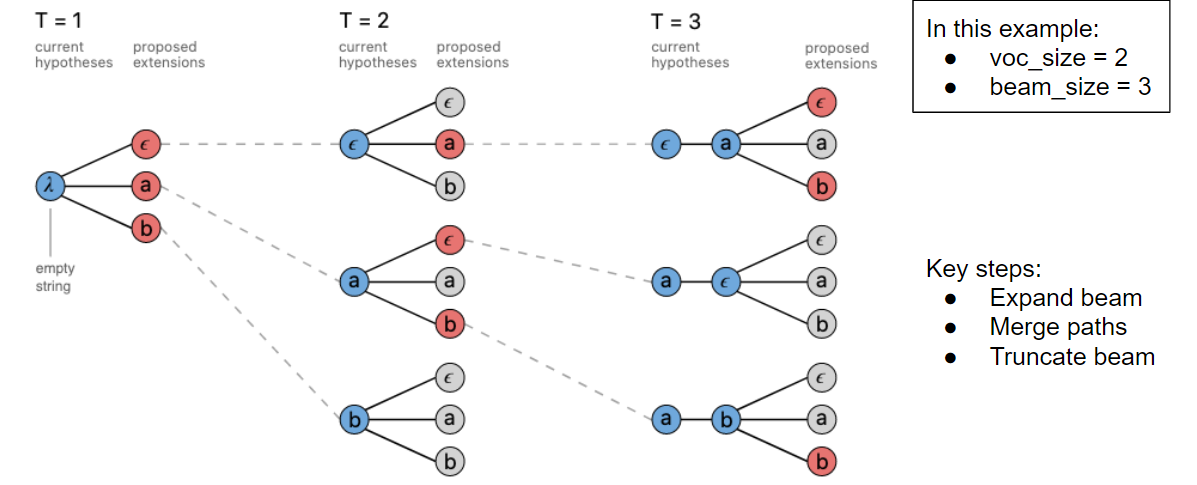

In [ ]:
# Load precomputed CTC output
with open('lj_batch.pickle', 'rb') as f:
    batch = pickle.load(f)

# log probabilities of softmax layers [batch_size, T, vocab_size]
log_probs = batch["log_probs"]

# Dictionary with index to character mapping
ind2char = batch["ind2char"]

true_texts = batch["text"]

**Задание**: Напишите функцию для beam search

In [ ]:
from collections import defaultdict
from tqdm import tqdm

def ctc_beam_search(probs, beam_size, ind2char):
    dp = {
        "": 1.0
    }

    for prob in probs:
        dp = extend_and_merge(dp, prob, ind2char)
        dp = cut_beams(dp, beam_size)

    return dp

def extend_and_merge(dp, prob, ind2char):
    new_dp = defaultdict(float)
    for string, v in dp.items():
        for i in ind2char:
            ch = ind2char[i]
            if (string and ch == string[-1]) or ch == EMPTY_TOK:
                new_dp[string] += v * prob[i]
            else:
                new_dp[string+ind2char[i]] += v * prob[i]
    return new_dp

def cut_beams(dp, beam_size):
    sorted_dp = sorted(dp.items(), key=lambda x: x[1])
    cut_dp = list(sorted_dp)[-beam_size:]
    return dict(cut_dp)

bs_results = []
for log_probs_line in log_probs:
    bs_results.append(ctc_beam_search(log_probs_line.exp().numpy(), 100, ind2char))

In [ ]:
for i in range(len(true_texts)):
    beam_search_hypos = sorted(bs_results[i].items(), key=lambda x: x[1], reverse=True)[:3]
    true_text = true_texts[i]
    argmax_text = ctc_decode(log_probs[i].numpy().argmax(-1), ind2char)
    print("True: ", true_text)
    print(f"Argmax: {argmax_text} --- (CER: {calc_cer(true_text, argmax_text):.3f})")
    for ind, (hypo, score) in enumerate(beam_search_hypos):
        print(f"{ind+1}) '{hypo}' --- (CER: {calc_cer(true_text, hypo):.3f})")
    print('-' * 100)

True:  he would go to her and tell her all his family complications
Argmax: he wld ge toher iand tel her al mhisan ly omblications --- (CER: 0.233)
1) 'he wl ge to her iand tel her al hisanly omblications' --- (CER: 0.217)
2) 'he wl ge to her and tel her al hisanly omblications' --- (CER: 0.200)
3) 'he wl ge to her iand tel her al hisan ly omblications' --- (CER: 0.217)
----------------------------------------------------------------------------------------------------
True:  he did not say the last as a boast but merely as an assurance to the liveryman who he saw was anxious on his account
Argmax: he did not sad the last is a bost but mearlioves an asurance to the livery man who re saw was anxes on his acount --- (CER: 0.138)
1) 'he did not say the last is a bost but merli aves an asurance to the livery man who re saw was anxes on his acount' --- (CER: 0.112)
2) 'he did not say the last is a bost but merli aves an asurance to the livery man who re saw was anxeus on his acount' --- (CE